# Exercise 28 Solution - Variational Autoencoder

### Task
Train a variational autoencoder (on a dataset composed of circles, squares, triangles and crosses) and generate new samples

### Learning goals
- Understand the difference between an autoencoder and a variational autoencoder
- Familiarize yourself with the implementational details of variational autoencoders
- Use the latent space to deepen your understanding on how autoencoders operate (and how the Kullback-Leibler divergence changes the behavior in the latent space: change beta to experience the change in influence)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torchsummary import summary

In [2]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

## Hyperparameters

**data generation parameters**

In [3]:
N = 128
domainLength = 1
numberOfCircles = 5
radius = 0.12
min_max_side_length = (0.8, 0.8)
numberOfSamples = 1280

**neural network parameters**

In [4]:
latent_dim = 2  # 16, 32, 64, 128

**training parameters**

In [5]:
learning_rate = 1e-3  # 2e-3 = nice structure, 1e-3 = also not bad, 5e-3 = too high
batch_size = 16
epochs = 20  #100 to improve the results
beta = 300  # figures in chapter generated with beta = 1000, 200, 0 (for 2D latent space)

# Data generation

**helper functions to generate shapes**

In [6]:
def draw_circle(N, domainLength, x_center, y_center, diameter):
    domain = np.ones((N, N))
    radius = diameter / 2
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    X, Y = np.meshgrid(x, y)
    mask = (X - x_center) ** 2 + (Y - y_center) ** 2 <= radius ** 2
    domain[mask] = -1
    return domain


def draw_square(N, domainLength, x_center, y_center, side_length):
    domain = np.ones((N, N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    X, Y = np.meshgrid(x, y)
    mask = (np.abs(X - x_center) <= side_length / 2) & (np.abs(Y - y_center) <= side_length / 2)
    domain[mask] = -1
    return domain


def draw_triangle(N, domainLength, x_center, y_center, height):
    domain = np.ones((N, N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    X, Y = np.meshgrid(x, y)

    # Height of the equilateral triangle
    side_length = 2 / np.sqrt(3) * height

    # Calculate vertices of the triangle
    v_top = (x_center, y_center - 2 * height / 3)  # Top vertex
    v_left = (x_center - side_length / 2, y_center + height / 3)  # Bottom left vertex
    v_right = (x_center + side_length / 2, y_center + height / 3)  # Bottom right vertex

    # Create mask for points inside the triangle using cross products
    mask = (
            ((X - v_top[0]) * (v_left[1] - v_top[1]) - (Y - v_top[1]) * (v_left[0] - v_top[0]) >= 0) &
            ((X - v_left[0]) * (v_right[1] - v_left[1]) - (Y - v_left[1]) * (v_right[0] - v_left[0]) >= 0) &
            ((X - v_right[0]) * (v_top[1] - v_right[1]) - (Y - v_right[1]) * (v_top[0] - v_right[0]) >= 0)
    )

    domain[mask] = -1
    return domain


def draw_cross(N, domainLength, x_center, y_center, arm_length):
    domain = np.ones((N, N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    X, Y = np.meshgrid(x, y)

    arm_width = arm_length / 3

    # Create masks for the vertical and horizontal bars of the cross
    vertical_bar = (np.abs(X - x_center) <= arm_width / 2) & (np.abs(Y - y_center) <= arm_length / 2)
    horizontal_bar = (np.abs(X - x_center) <= arm_length / 2) & (np.abs(Y - y_center) <= arm_width / 2)

    # Combine the masks to form the cross
    mask = vertical_bar | horizontal_bar
    domain[mask] = -1
    return domain


# Function to generate either a circle, a square or a triangle
def generate_shapes(N, domainLength, min_max_side_length, shape=None):
    if shape is None:
        shape = np.random.randint(0, 4)  # Random shape type between 0 and 3

    if shape == 0:  # Circle
        diameter = np.random.uniform(*min_max_side_length)
        x_center = np.random.uniform(diameter / 2, domainLength - diameter / 2)
        y_center = np.random.uniform(diameter / 2, domainLength - diameter / 2)
        domain = draw_circle(N, domainLength, x_center, y_center, diameter)

    elif shape == 1:  # Square
        side_length = np.random.uniform(*min_max_side_length)
        x_center = np.random.uniform(side_length / 2, domainLength - side_length / 2)
        y_center = np.random.uniform(side_length / 2, domainLength - side_length / 2)
        domain = draw_square(N, domainLength, x_center, y_center, side_length)

    elif shape == 2:  # Triangle
        height = np.random.uniform(*min_max_side_length)
        side_length = 2 / np.sqrt(3) * height
        x_center = np.random.uniform(side_length / 2, domainLength - side_length / 2)
        y_center = np.random.uniform(side_length / 2, domainLength - side_length / 2)
        domain = draw_triangle(N, domainLength, x_center, y_center, height)

    else:  # Cross
        arm_length = np.random.uniform(*min_max_side_length)
        x_center = np.random.uniform(arm_length / 2, domainLength - arm_length / 2)
        y_center = np.random.uniform(arm_length / 2, domainLength - arm_length / 2)
        domain = draw_cross(N, domainLength, x_center, y_center, arm_length)

    return domain, shape

**data generation**

In [7]:
samples = np.zeros((numberOfSamples, 1, N, N))
shapes = np.zeros((numberOfSamples, 1))
for k in range(numberOfSamples):
    domain, shape = generate_shapes(N, domainLength, min_max_side_length)
    samples[k, 0] = domain
    shapes[k] = shape
torch.save(torch.from_numpy(samples).to(torch.float32), f"data/shapeData{N}.pt")
torch.save(torch.from_numpy(shapes).to(torch.float32), f"data/shapeLabels{N}.pt")

**visualization of each shape**

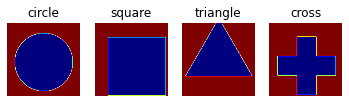

In [8]:
labels = ['circle', 'square', 'triangle', 'cross']
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes):
    sample = samples[shapes == i][1].squeeze()
    ax.imshow(sample, cmap='jet')
    ax.set_title(f'{labels[i]}')
    ax.axis('off')

## Variational autoencoder architecture definition

In [9]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder with PReLU activation
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(init=0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(init=0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(init=0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.PReLU(init=0.2),
        )

        # Flatten layer
        self.flatten = nn.Flatten()

        # Linear layers for mean and log variance
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

        # Decoder input
        self.decoder_input = nn.Linear(latent_dim, 256 * 8 * 8)

        # Decoder with PReLU activation
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(init=0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(init=0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(init=0.2),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, 8, 8)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var

## Dataset definition

**load generated data into PyTorch dataset**

In [10]:
class microstructureDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)

        if self.labels is None:
            return sample, 0
        else:
            label = self.labels[idx]
            return sample, label

## Loss function

In [11]:
def loss_function(recon_x, x, mu, log_var, beta=1):
    loss_fn = nn.MSELoss(reduction='sum')
    recon_loss = loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (recon_loss + beta * kl_loss) / x.size(0) / 128 ** 2

## Training

**data preparation including training/validation split**

In [12]:
data = torch.load("data/shapeData128.pt", weights_only=False)
data = data / 2 + 0.5  # does 0-1 normalization
labels = torch.load('data/shapeLabels128.pt', weights_only=False)
dataset = microstructureDataset(data, labels)
datasetTraining, datasetValidation = torch.utils.data.dataset.random_split(dataset, [0.9, 0.1])
dataloaderTraining = DataLoader(datasetTraining, batch_size=batch_size, shuffle=True)
dataloaderValidation = DataLoader(datasetValidation, batch_size=batch_size, shuffle=False)  # all samples

**visualize a random training sample**

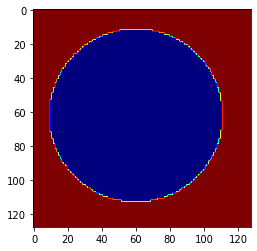

In [13]:
(batch, labels) = next(iter(dataloaderTraining))
img = batch[-1].squeeze()
plt.imshow(img, cmap='jet')
plt.show()

**neural network instantiation**

In [14]:
model = VAE(latent_dim=latent_dim)
summary(model, (1, 128, 128))
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             PReLU-3           [-1, 32, 64, 64]               1
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
             PReLU-6           [-1, 64, 32, 32]               1
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
             PReLU-9          [-1, 128, 16, 16]               1
           Conv2d-10            [-1, 256, 8, 8]         295,168
      BatchNorm2d-11            [-1, 256, 8, 8]             512
            PReLU-12            [-1, 256, 8, 8]               1
          Flatten-13                [-1, 16384]               0
           Linear-14                   

**optimizer and history**

In [15]:
opt = optim.Adam(model.parameters(), lr=learning_rate)

costHistoryTrain = np.zeros(epochs)
costHistoryValidation = np.zeros(epochs)

**training loop**

In [16]:
start = time.perf_counter()
start0 = start
bestCost = 1e10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch, (x, y) in enumerate(dataloaderTraining):
        x = x.to(device)
        opt.zero_grad()

        x_hat, mu, log_var = model(x)
        loss = loss_function(x_hat, x, mu, log_var, beta)
        loss.backward()
        opt.step()

        total_loss += loss.item()

    costHistoryTrain[epoch] = total_loss / (batch + 1)

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for batch, (x, y) in enumerate(dataloaderValidation):
            x = x.to(device)
            x_hat, mu, log_var = model(x)
            val_loss = loss_function(x_hat, x, mu, log_var, beta)
            total_val_loss += val_loss.item()

        costHistoryValidation[epoch] = total_val_loss / (batch + 1)

    if (epoch % 1 == 0):
        elapsed_time = time.perf_counter() - start
        string = "Epoch: {}/{}\t\tCost function (Train): {:.3E}\t\tCost function (Validation): {:.3E}\nElapsed time: {:2f}"
        print(string.format(epoch, epochs - 1, costHistoryTrain[epoch], costHistoryValidation[epoch], elapsed_time))
        start = time.perf_counter()

    # early stopping
    if bestCost > costHistoryValidation[epoch]:
        bestCost = costHistoryValidation[epoch]
        torch.save(model.state_dict(), "bestmodel.pt")
        bestEpoch = epoch

print("Total elapsed time: {:2f}".format(time.perf_counter() - start0))
print("best epoch: {:d}".format(bestEpoch))
model.load_state_dict(
    torch.load("bestmodel.pt", map_location=device, weights_only=False))  # load best result from early stopping

Epoch: 0/19		Cost function (Train): 1.757E-01		Cost function (Validation): 1.301E-01
Elapsed time: 8.397685
Epoch: 1/19		Cost function (Train): 1.325E-01		Cost function (Validation): 1.277E-01
Elapsed time: 15.422187
Epoch: 2/19		Cost function (Train): 1.232E-01		Cost function (Validation): 1.220E-01
Elapsed time: 16.694250
Epoch: 3/19		Cost function (Train): 1.256E-01		Cost function (Validation): 1.410E-01
Elapsed time: 11.261168
Epoch: 4/19		Cost function (Train): 1.187E-01		Cost function (Validation): 1.167E-01
Elapsed time: 11.662743
Epoch: 5/19		Cost function (Train): 1.159E-01		Cost function (Validation): 1.212E-01
Elapsed time: 11.616896
Epoch: 6/19		Cost function (Train): 1.198E-01		Cost function (Validation): 1.306E-01
Elapsed time: 11.347284
Epoch: 7/19		Cost function (Train): 1.160E-01		Cost function (Validation): 1.260E-01
Elapsed time: 10.857866
Epoch: 8/19		Cost function (Train): 1.156E-01		Cost function (Validation): 1.192E-01
Elapsed time: 11.895386
Epoch: 9/19		Cost fu

<All keys matched successfully>

## Post-processing

In [17]:
model.eval().to(device=device)
print("validation cost: {:.2e} training cost: {:.2e}".format(np.min(costHistoryValidation), np.min(costHistoryTrain)))

validation cost: 1.10e-01 training cost: 1.06e-01


**training history**

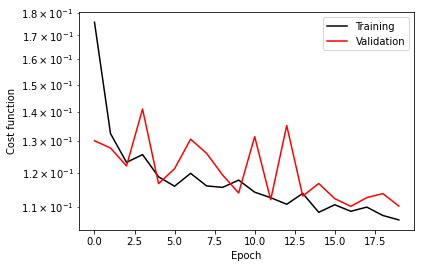

In [18]:
fig, ax = plt.subplots()
ax.plot(costHistoryTrain, 'k')
ax.plot(costHistoryValidation, 'r')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cost function')
ax.legend(['Training', 'Validation'])
plt.show()

**prediction of training sample**

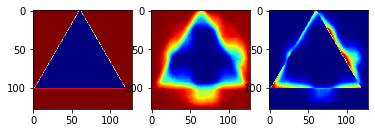

In [19]:
(train_sample, train_labels) = next(iter(dataloaderTraining))
train_pred = model(train_sample.to(device=device))[0]
train_pred = train_pred.detach().cpu()
index = 0
fig, ax = plt.subplots(1, 3)
ax[0].imshow(train_sample[index, 0], cmap='jet')
ax[1].imshow(train_pred[index, 0], cmap='jet')
ax[2].imshow((train_sample[index, 0] - train_pred[index, 0]) ** 2, cmap='jet')
for i in range(3):
    ax[i].axis('off')
plt.show()

**prediction of validation sample**

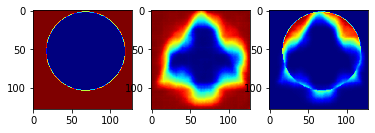

In [20]:
(val_sample, val_labels) = next(iter(dataloaderValidation))
val_pred = model(val_sample.to(device=device))[0]
val_pred = val_pred.detach().cpu()
index = 0
fig, ax = plt.subplots(1, 3)
ax[0].imshow(val_sample[index, 0], cmap='jet')
ax[1].imshow(val_pred[index, 0], cmap='jet')
ax[2].imshow((val_sample[index, 0] - val_pred[index, 0]) ** 2, cmap='jet')
for i in range(3):
    ax[i].axis('off')
plt.show()

**generate 16 random samples (not part of dataset)**

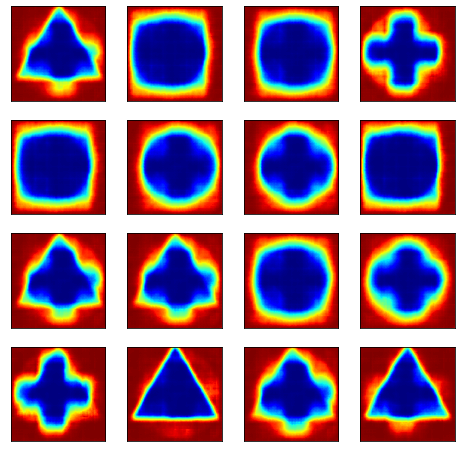

In [39]:
z = torch.randn(16, latent_dim).to(device=device)
samples = model.decode(z)
samples = samples.detach().cpu()
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(samples[i * 4 + j, 0], cmap='jet')
        ax[i, j].axis('off')
plt.show()

**visualize latent space**

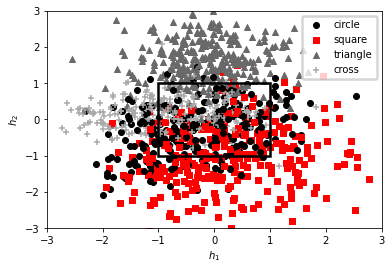

In [29]:
if latent_dim == 2:
    def plot_latent(vae, data):
        markers = {0: 'o', 1: 's', 2: '^', 3: '+'}  # square, triangle, circle
        colors = {0: 'k', 1: 'r', 2: 'dimgray', 3: 'darkgray'}  # red, green, blue
        labels = {0: 'circle', 1: 'square', 2: 'triangle', 3: 'cross'}

        fig, ax = plt.subplots()
        ax.set_axisbelow(True)

        for i, (x, y) in enumerate(data):
            mu, log_var = vae.encode(x.to(device))
            z = vae.reparameterize(mu, log_var)
            z = z.to('cpu').detach().numpy()
            y = y.to('cpu').numpy().flatten()

            for shape in np.unique(y):
                mask = y == shape
                plt.scatter(z[mask, 0], z[mask, 1], c=colors[shape], marker=markers[shape], label=f'{labels[shape]}')

        square = matplotlib.patches.Rectangle((-1, -1), 2, 2, edgecolor='black', facecolor='none', linewidth=2.5)
        ax.add_patch(square)

        ax.set_xlabel("$h_1$")
        ax.set_ylabel("$h_2$")
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        legend = ax.legend(by_label.values(), by_label.keys())

        plt.ylim(-3, 3)
        plt.xlim(-3, 3)
        legend.get_frame().set_linewidth(2.5)
        plt.show()


    plot_latent(model, dataloaderTraining)

**visualize samples in latent space**

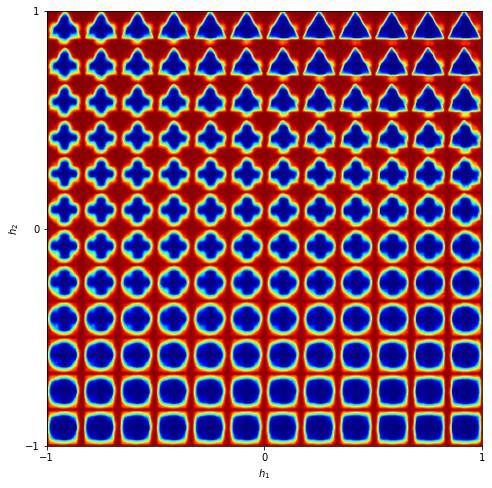

In [35]:
if latent_dim == 2:
    def plot_reconstructed(autoencoder, r0=(-5, 5), r1=(-5, 5), n=12, resolution=128):
        fig, ax = plt.subplots(figsize=(8, 8))
        w = resolution
        img = np.zeros((n * w, n * w))
        for i, y in enumerate(np.linspace(*r1, n)):
            for j, x in enumerate(np.linspace(*r0, n)):
                z = torch.Tensor([[x, y]]).to(device)
                x_hat = autoencoder.decode(z)
                x_hat = x_hat.detach().cpu()
                img[(n - 1 - i) * w:(n - 1 - i + 1) * w, j * w:(j + 1) * w] = x_hat
        plt.imshow(img, extent=[*r0, *r1], cmap='jet')
        plt.xticks([i for i in [-1, 0, 1]])  # adjust according to scale
        plt.yticks([i for i in [-1, 0, 1]])  # adjust according to scale

        plt.clim(0.0, 1.0)

        ax.set_xlabel("$h_1$")
        ax.set_ylabel("$h_2$")
        plt.show()


    lim = 1.0
    plot_reconstructed(model, r0=(-lim, lim), r1=(-lim, lim), n=12, resolution=128)
